The inputs to HPM tables are (M,r).
The table outputs are in rho, fscalar (or psi) and T.
But only M,r on a grid; rho and fscalar are distributed irregularly so we need to interpolate between these irregular points. In normal numpy/scipy thers is the function ```griddata``` to do this. But this specific function does not exist in jax. Therefore we use an alternative approach using Gaussian process + RBF kernel.

In [37]:
import numpy as np

# Load data to train the GP
a=np.load('/project/chihway/yomori/repo/Baryonator/src/sampling/Xtrain.npy') # rho, fscaler
b=np.load('/project/chihway/yomori/repo/Baryonator/src/sampling/ytrain.npy') # T

Text(0, 0.5, '$\\log_{10} (f_{\\rm scalar})$')

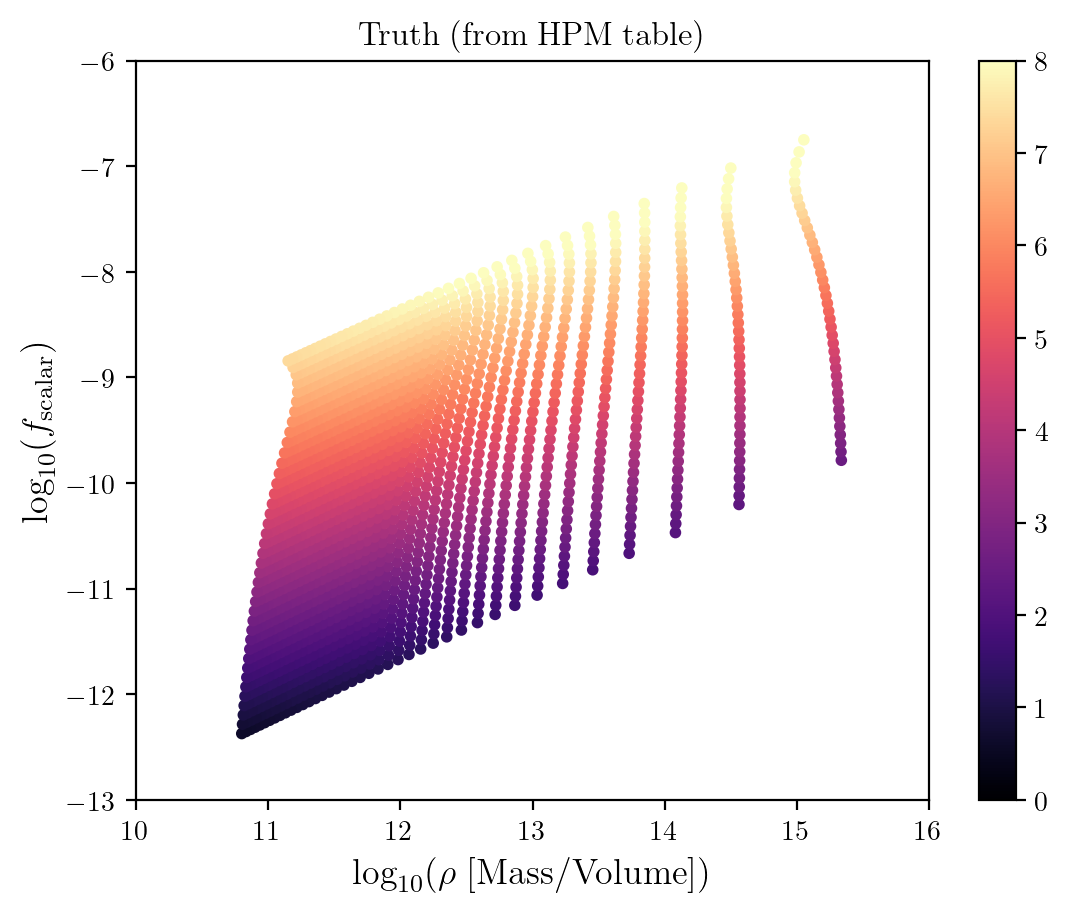

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

sc=plt.scatter(a[:,0],a[:,1],c=b,s=10,vmin=0, vmax=8,cmap='magma')
plt.colorbar(sc)
plt.ylim(-13,-6)
plt.xlim(10,16)
plt.title(r'${\rm Truth\ (from\ HPM\ table)}$')
plt.xlabel(r"${\rm log}_{10}(\rho\ [{\rm Mass/Volume}]) $",size=13)
plt.ylabel(r"$\log_{10} (f_{\rm scalar})$",size=13)


Just as a demonstration here is an example using ```scipy.grididata```

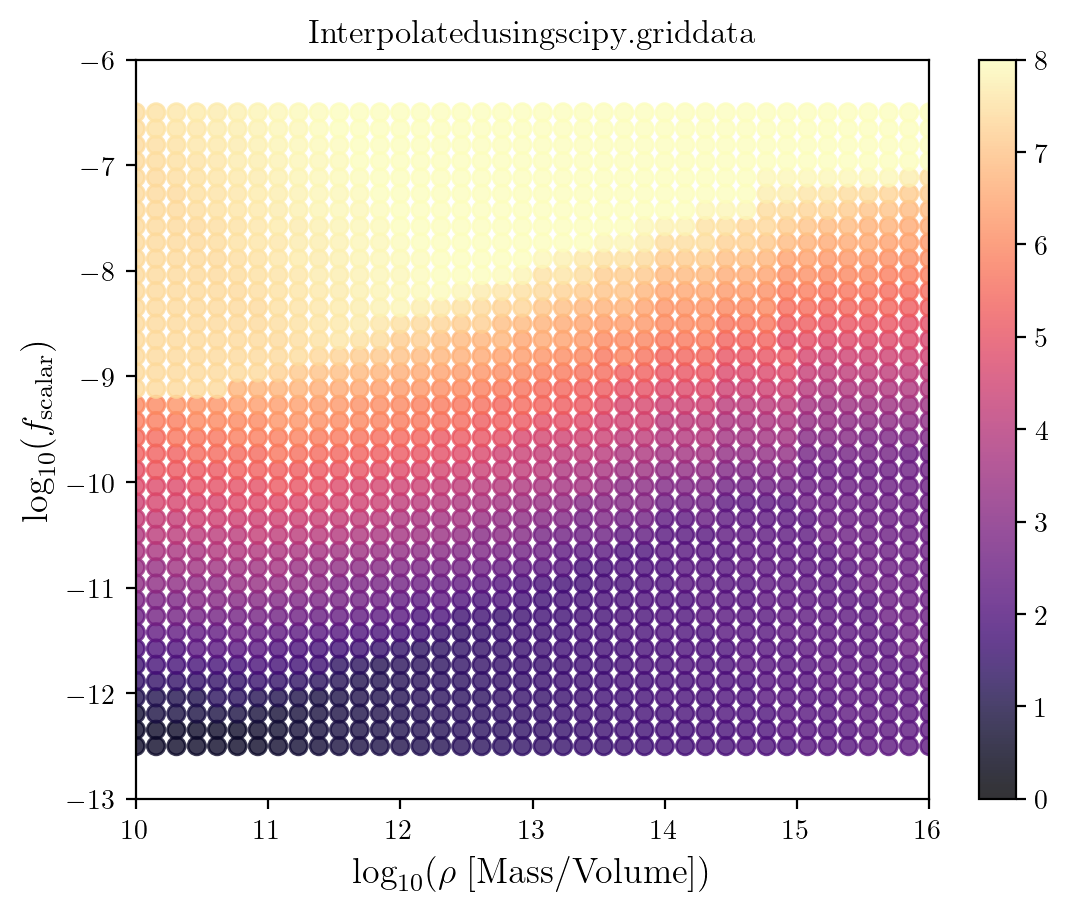

In [48]:
from scipy.interpolate import griddata

# Make meshgrid (specify locations to evaluate)
grid_x, grid_y = np.mgrid[10:16:40j, -12.5:-6.5:40j]

# Evaluate values using nearest interpolation, which is probably bad
grid_z1 = griddata(a, b, (grid_x, grid_y), method='nearest')

# Plot 
sc=plt.scatter(grid_x.flatten(),grid_y.flatten(),c=grid_z1.flatten(),vmin=0, vmax=8,s=40,cmap='magma',alpha=0.8)
plt.colorbar(sc)
plt.ylim(-13,-6)
plt.xlim(10,16)

plt.title(r'${\rm Interpolated using scipy.griddata}$')
plt.xlabel(r"${\rm log}_{10}(\rho\ [{\rm Mass/Volume}]) $",size=13)
plt.ylabel(r"$\log_{10} (f_{\rm scalar})$",size=13);


Now implement the Gaussian process + RBF

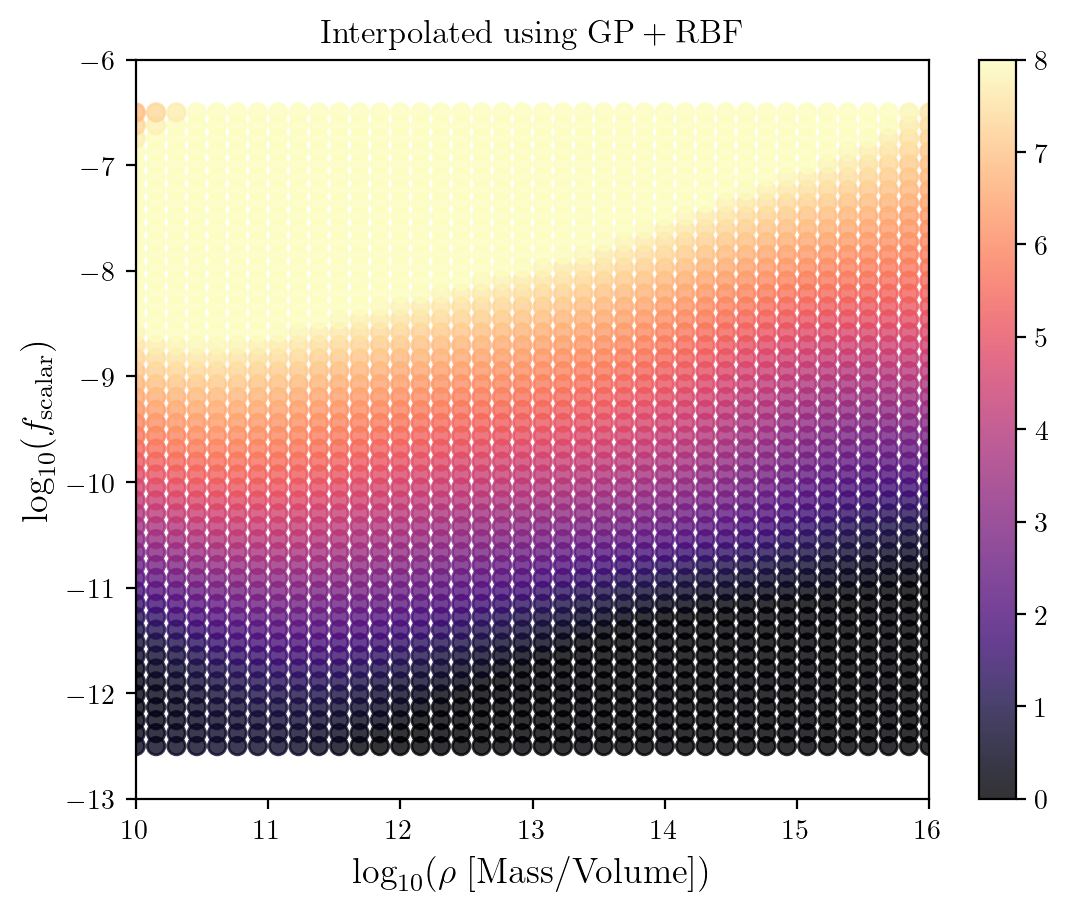

In [49]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# 2D RBF kernel
def rbf_kernel(x1, x2, length_scale=1.4, variance=0.5):
    # x1, x2 have shape [num_samples, 2]
    delta = x1[:, None, :] - x2[None, :, :]
    squared_distance = jnp.sum(delta ** 2, axis=-1)
    return variance * jnp.exp(-0.5 * squared_distance / (length_scale ** 2))

# GP posterior
def gp_posterior(X_train, y_train, X_test, kernel_func, noise_variance=4e-5):
    K = kernel_func(X_train, X_train) + noise_variance * jnp.eye(X_train.shape[0])
    Ks = kernel_func(X_train, X_test)
    Kss = kernel_func(X_test, X_test)

    K_inv = jnp.linalg.inv(K)
    mu_s = jnp.dot(Ks.T, jnp.dot(K_inv, y_train))

    return mu_s

# Define training points
X_train = a
y_train = b

# Just as a demonstration use the same grid as used for the scipy.griddata example 
x = jnp.linspace(10, 16, 40)
y = jnp.linspace(-12.5, -6.5, 50)
xx,yy=np.meshgrid(x,y)

# Use GP to prdict values at the grid points
mu_s = gp_posterior(X_train, y_train, np.c_[xx.flatten(),yy.flatten()], rbf_kernel)

# Plot 
sc=plt.scatter(xx.flatten(),yy.flatten(),c=mu_s,vmin=0, vmax=8, s=40,cmap='magma',alpha=0.8)
plt.colorbar(sc)
plt.ylim(-13,-6)
plt.xlim(10,16)

plt.title(r'${\rm Interpolated\ using\ GP+RBF}$')
plt.xlabel(r"${\rm log}_{10}(\rho\ [{\rm Mass/Volume}]) $",size=13)
plt.ylabel(r"$\log_{10} (f_{\rm scalar})$",size=13);


Note that parameters like ```length_scale=1.4```, ```variance=0.5``` and ```noise_variance=4e-5``` need tuning.
Now try applying to the same points as the hpm table

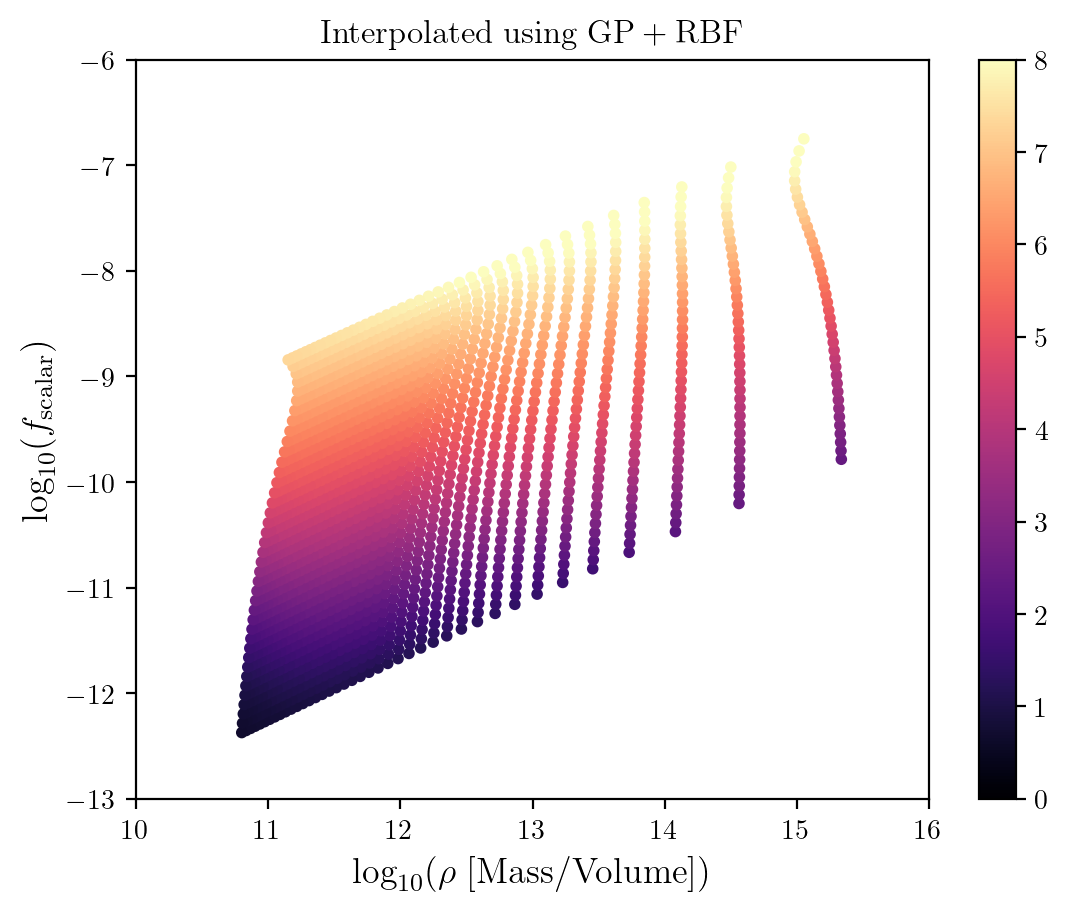

In [50]:
mu_s = gp_posterior(X_train, y_train, np.c_[X_train[:,0],X_train[:,1]], rbf_kernel)
sc=plt.scatter(X_train[:,0],X_train[:,1],c=mu_s,vmin=0, vmax=8,s=10,cmap='magma')
plt.colorbar(sc)
plt.ylim(-13,-6)
plt.xlim(10,16)
plt.title(r'${\rm Interpolated\ using\ GP+RBF}$')
plt.xlabel(r"${\rm log}_{10}(\rho\ [{\rm Mass/Volume}]) $",size=13)
plt.ylabel(r"$\log_{10} (f_{\rm scalar})$",size=13);


and also check the difference:

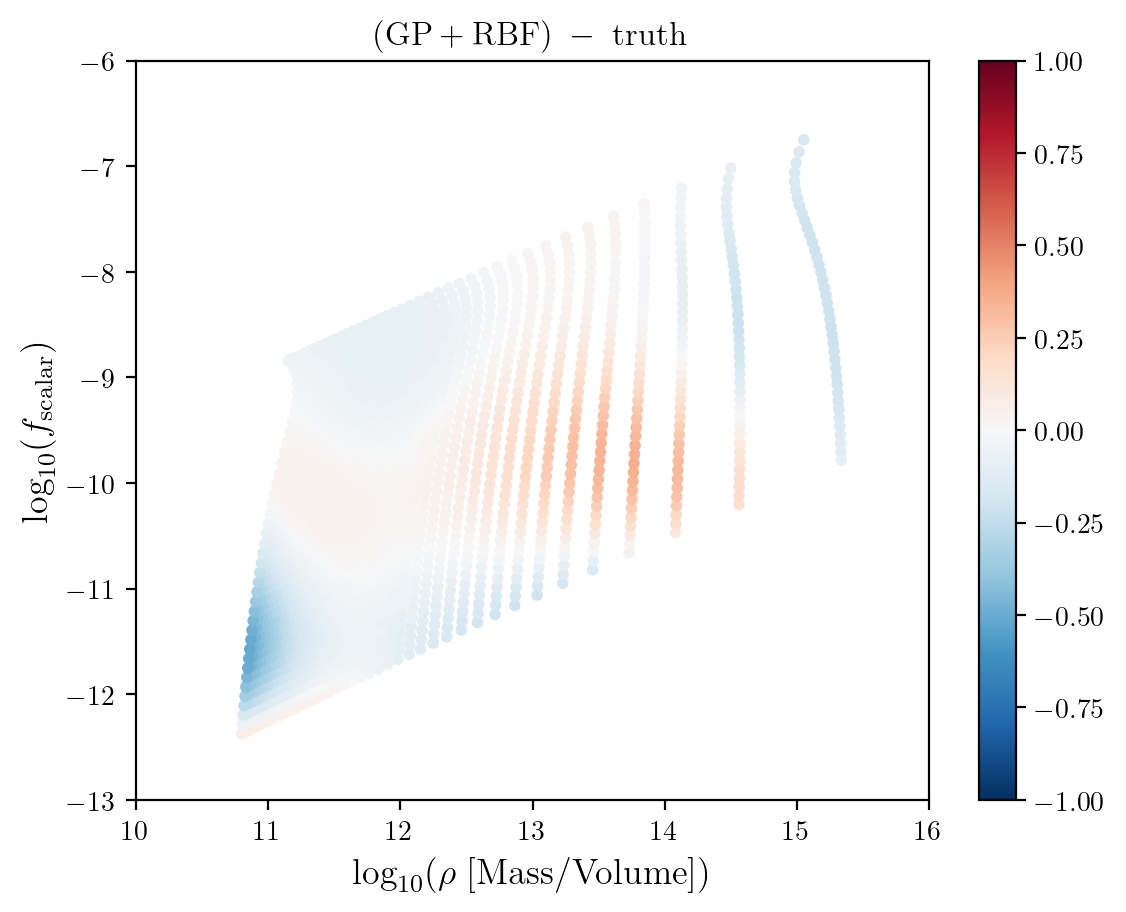

In [51]:
sc=plt.scatter(X_train[:,0],X_train[:,1],c=mu_s-b,vmin=-1, vmax=1,s=10,cmap='RdBu_r')

plt.ylim(-13,-6)
plt.xlim(10,16)
plt.colorbar(sc)
plt.title(r'${\rm  (GP+RBF)\ -\ truth }$')
plt.xlabel(r"${\rm log}_{10}(\rho\ [{\rm Mass/Volume}]) $",size=13)
plt.ylabel(r"$\log_{10} (f_{\rm scalar})$",size=13);
